# Cell State Identification

In [73]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import scvi

In [74]:
flu_data = sc.read_h5ad("../data/inference/influenza_lee_czi_preds.h5ad")
covid_data = sc.read_h5ad("../data/inference/covid_all_czi_preds.h5ad")

# COVID Data - Monocyte Cell States

In [94]:
covid_monocyte_mask = covid_data.obs["pred_coarse"].str.contains("cd14", case=False, na=False)
covid_data_mono = covid_data[covid_monocyte_mask].copy()

In [95]:
covid_data_mono.obsm["X_scgpt"] = covid_data_mono.obsm["X_scgpt"]  # redundant but safe
sc.pp.neighbors(covid_data_mono, use_rep="X_scgpt")
sc.tl.umap(covid_data_mono)  # reuse or recalculate UMAP
sc.tl.leiden(covid_data_mono, resolution=0.2)  # experiment with resolution

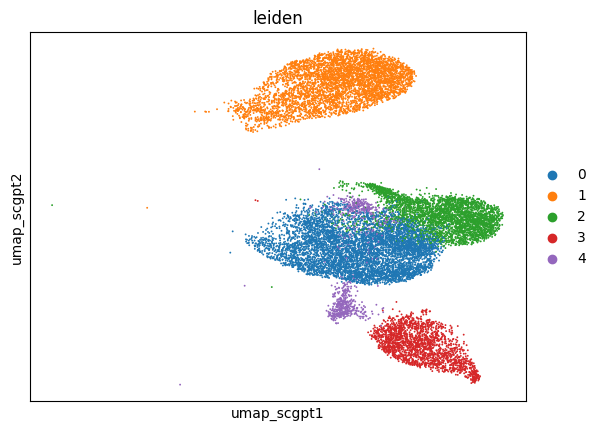

In [96]:
sc.pl.embedding(covid_data_mono, basis="umap_scgpt", color=["leiden"])

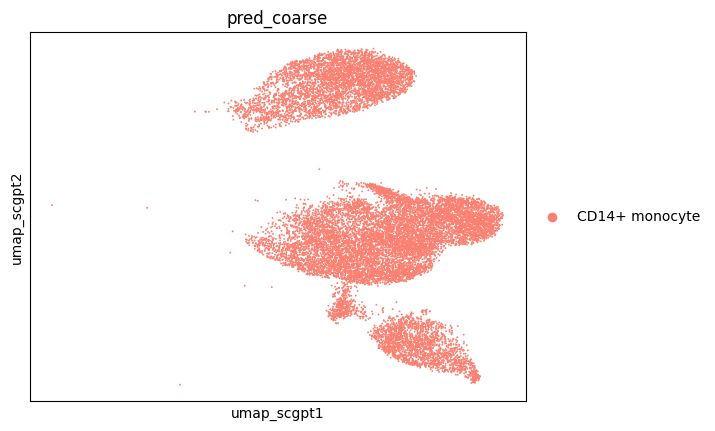

In [97]:
sc.pl.embedding(covid_data_mono, basis="umap_scgpt", color=["pred_coarse"])

In [98]:
if "log1p" not in covid_data_mono.uns:
    sc.pp.normalize_total(covid_data_mono, target_sum=1e4)
    sc.pp.log1p(covid_data_mono)

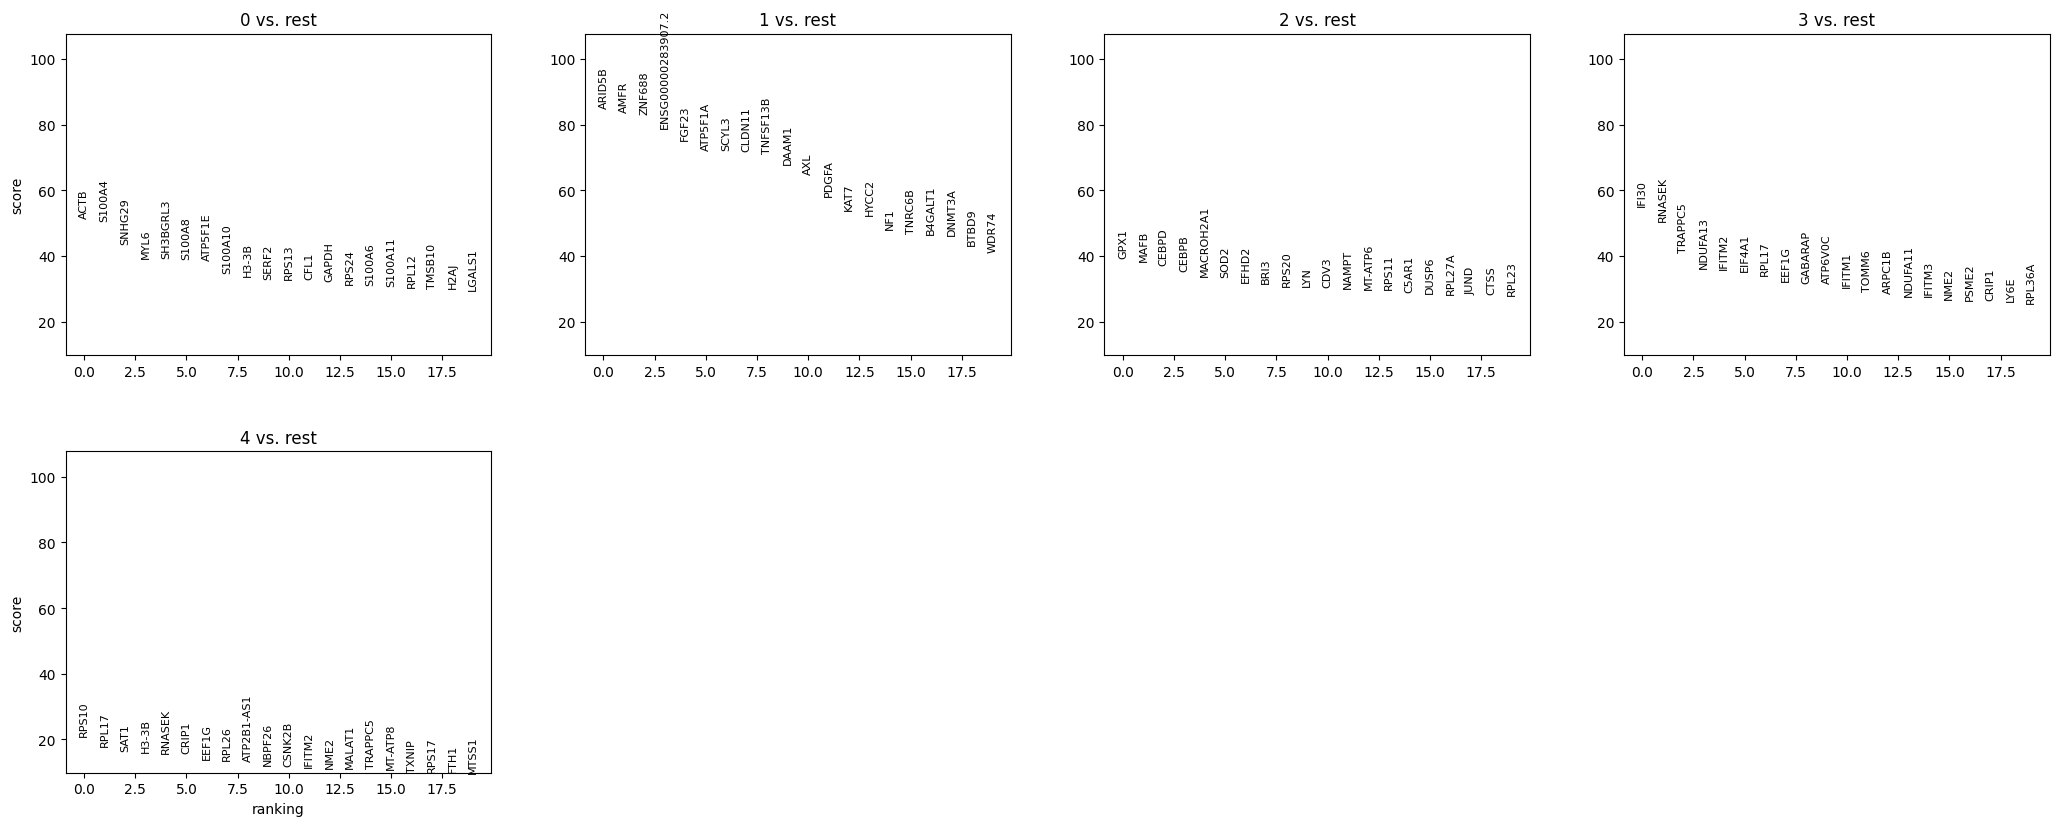

In [99]:
# 4. Rank genes for differential expression (e.g., by cluster, condition)
sc.tl.rank_genes_groups(covid_data_mono, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(covid_data_mono)

/tmp/ipykernel_2406299/1509839576.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_genes
/tmp/ipykernel_2406299/1509839576.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_genes


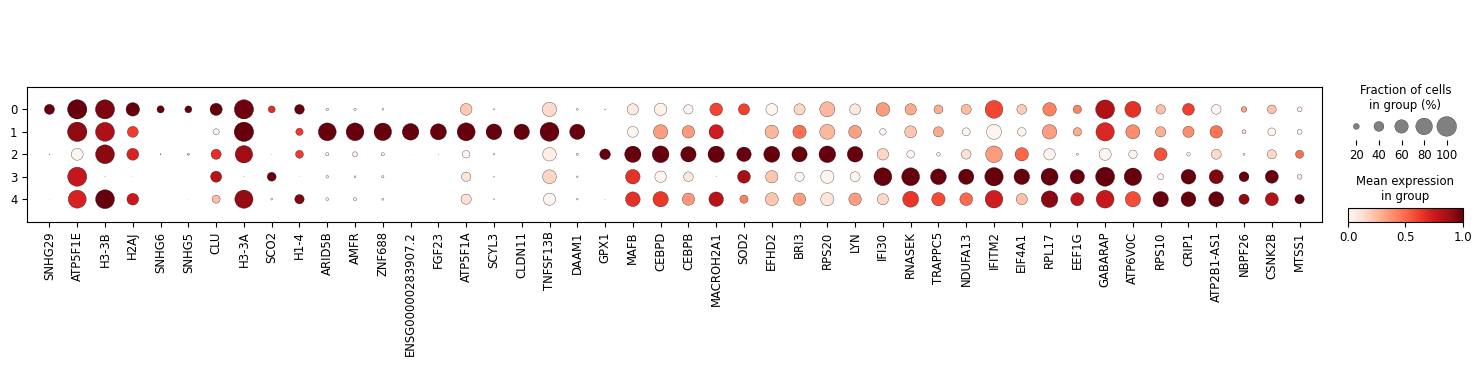

In [123]:
import pandas as pd

# 2. Extract ranked gene data
ranked_df = sc.get.rank_genes_groups_df(covid_data_mono, None)  # all groups

# 3. Filter for high-confidence genes (LFC > 1, adj p < 0.05)
valid_genes = ranked_df[
    (ranked_df['pvals_adj'] < 0.05) &
    (ranked_df['logfoldchanges'] > 1)
]

# 4. Select top N genes per cluster
top_n = 10
top_genes_per_cluster = (
    valid_genes
    .groupby("group")
    .apply(lambda g: g.sort_values("scores", ascending=False).head(top_n))
    .reset_index(drop=True)
)

# 5. Get unique list of marker genes
marker_genes = top_genes_per_cluster["names"].unique().tolist()

known_state_genes = [
    "CD14", "FCGR3A", "LYZ",     # classical markers
    "S100A8", "S100A9",          # inflammatory
    "IFITM1", "IFI6", "ISG15"    # interferon response
]
combined_genes = list(set(marker_genes + known_state_genes))

# 6. Plot dotplot showing expression of top genes per cluster
sc.pl.dotplot(covid_data_mono, var_names=marker_genes, groupby="leiden", standard_scale='var')

# Flu Data - Monocyte Cell States

In [101]:
flu_monocyte_mask = flu_data.obs["pred_coarse"].str.contains("cd14", case=False, na=False)
flu_data_mono = flu_data[flu_monocyte_mask].copy()

In [118]:
flu_data_mono.obsm["X_scgpt"] = flu_data_mono.obsm["X_scgpt"]  # redundant but safe
sc.pp.neighbors(flu_data_mono, use_rep="X_scgpt")
sc.tl.umap(flu_data_mono)  # reuse or recalculate UMAP
sc.tl.leiden(flu_data_mono, resolution=0.3)  # experiment with resolution

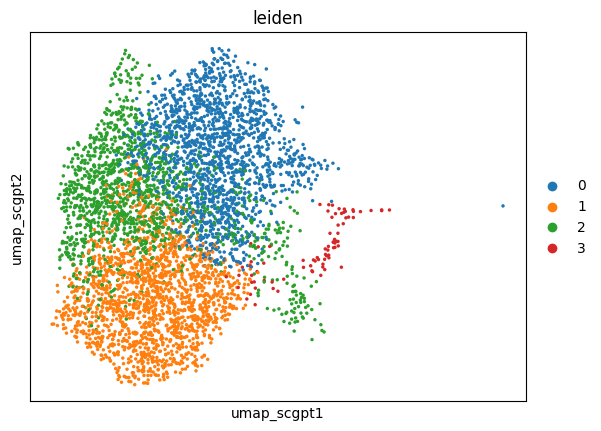

In [119]:
sc.pl.embedding(flu_data_mono, basis="umap_scgpt", color=["leiden"])

In [120]:
if "log1p" not in flu_data_mono.uns:
    sc.pp.normalize_total(flu_data_mono, target_sum=1e4)
    sc.pp.log1p(flu_data_mono)

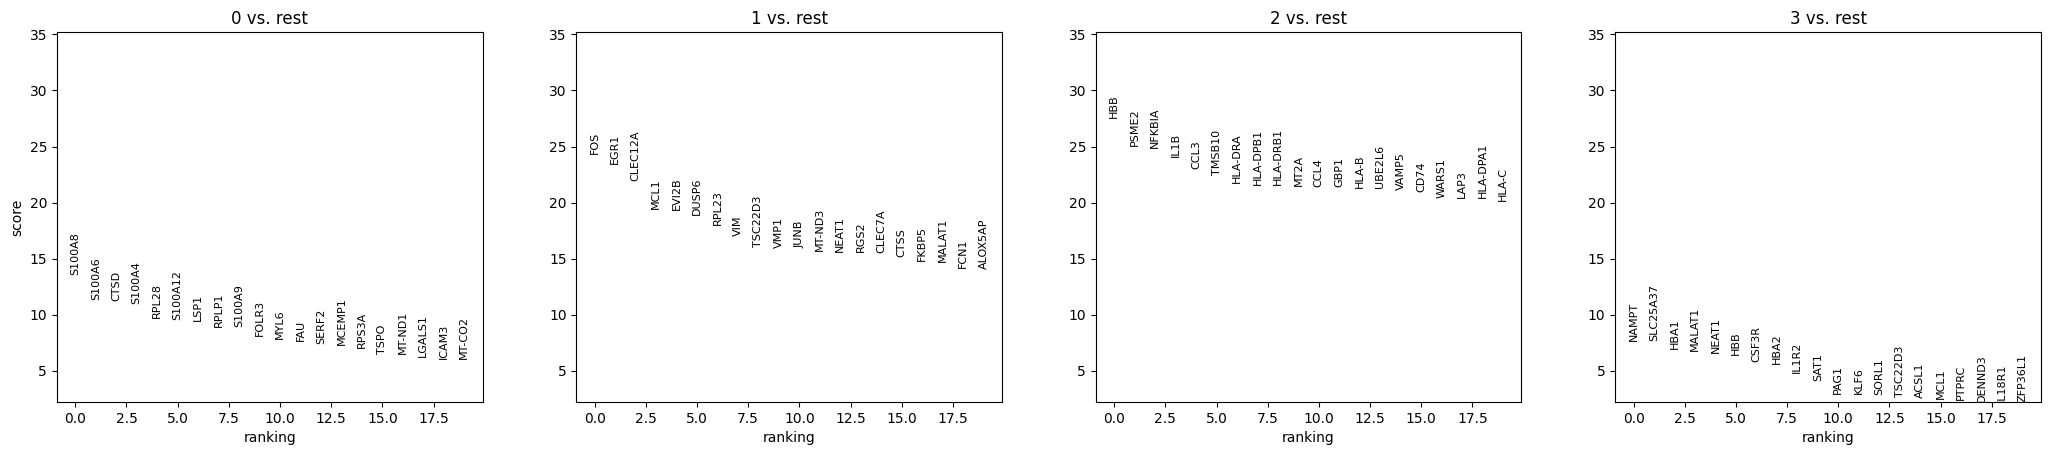

In [121]:
# 4. Rank genes for differential expression (e.g., by cluster, condition)
sc.tl.rank_genes_groups(flu_data_mono, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(flu_data_mono)

/tmp/ipykernel_2406299/1005759323.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_genes
/tmp/ipykernel_2406299/1005759323.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_genes


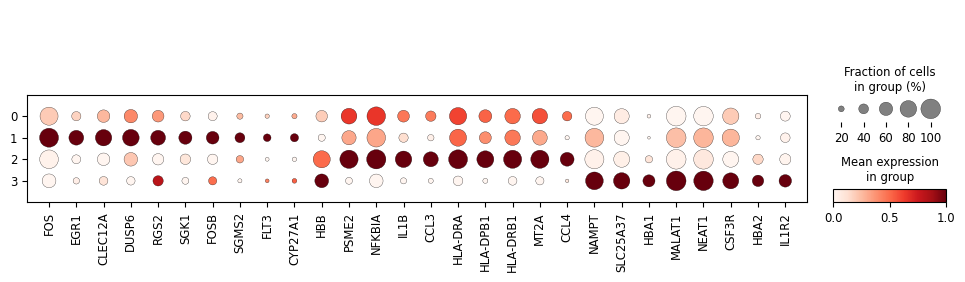

In [124]:
import pandas as pd

# 2. Extract ranked gene data
ranked_df = sc.get.rank_genes_groups_df(flu_data_mono, None)  # all groups

# 3. Filter for high-confidence genes (LFC > 1, adj p < 0.05)
valid_genes = ranked_df[
    (ranked_df['pvals_adj'] < 0.05) &
    (ranked_df['logfoldchanges'] > 1)
]

# 4. Select top N genes per cluster
top_n = 10
top_genes_per_cluster = (
    valid_genes
    .groupby("group")
    .apply(lambda g: g.sort_values("scores", ascending=False).head(top_n))
    .reset_index(drop=True)
)

# 5. Get unique list of marker genes
marker_genes = top_genes_per_cluster["names"].unique().tolist()

known_state_genes = [
    "CD14", "FCGR3A", "LYZ",     # classical markers
    "S100A8", "S100A9",          # inflammatory
    "IFITM1", "IFI6", "ISG15"    # interferon response
]
combined_genes = list(set(marker_genes + known_state_genes))

# 6. Plot dotplot showing expression of top genes per cluster
sc.pl.dotplot(flu_data_mono, var_names=marker_genes, groupby="leiden", standard_scale='var')